In [1]:
import scipy.io as scipy
import os
import os.path as osp
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from tqdm import tqdm
import copy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
BASEDIR = os.getcwd()
MAP_NAME = 'NYC_Manhattan_Map.mat'
REQ_NAME = 'Requests.mat'
OUTPUT_NAME = 'Manhattan' 

map = scipy.loadmat(osp.join(BASEDIR, MAP_NAME))
map


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 17 12:05:22 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Arcs': array([[   1,    1,    4],
        [   2,    2,    4],
        [   3,    2,    7],
        ...,
        [9450, 4091, 4084],
        [9451, 4091, 4088],
        [9452, 4091, 4089]], dtype=uint16),
 'CityArcs': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]], dtype=uint8),
 'EdgeTimes': array([[16],
        [30],
        [38],
        ...,
        [45],
        [22],
        [52]], dtype=uint16),
 'Nodes': array([[ 1.0000000e+00,  4.0706991e+01, -7.4017946e+01],
        [ 2.0000000e+00,  4.0706175e+01, -7.4017930e+01],
        [ 3.0000000e+00,  4.0707914e+01, -7.4017808e+01],
        ...,
        [ 4.0890000e+03,  4.0871035e+01, -7.3911682e+01],
        [ 4.0900000e+03,  4.0873201e+0

In [5]:
map.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Arcs', 'CityArcs', 'EdgeTimes', 'Nodes', 'dijkstra_A', 'dijkstra_V'])

In [3]:
map = scipy.loadmat(osp.join(BASEDIR, MAP_NAME))
Edges = pd.DataFrame(map['Arcs'])
AdjacencyV = pd.DataFrame(map['CityArcs'])
EdgeTimes = pd.DataFrame(map['EdgeTimes'])
Nodes = pd.DataFrame(map['Nodes'])
dijkstra_A = pd.DataFrame(map['dijkstra_A'])
dijkstra_V = pd.DataFrame(map['dijkstra_V'])

In [4]:
dijkstra_V.head()

,0,1,2,3,4,5,6,7,8,9,...,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090
0,0,35,122,16,69,100,73,57,95,116,...,2633,2665,2650,2650,2732,2634,2718,2659,2681,2696
1,53,0,136,30,83,114,38,71,60,130,...,2622,2654,2639,2639,2721,2623,2707,2648,2670,2685
2,85,81,0,62,55,11,102,43,124,27,...,2544,2576,2561,2561,2643,2545,2629,2570,2592,2607
3,23,19,106,0,53,84,57,41,79,100,...,2617,2649,2634,2634,2716,2618,2702,2643,2665,2680
4,47,43,70,24,0,48,81,5,103,64,...,2581,2613,2598,2598,2680,2582,2666,2607,2629,2644


In [37]:
EdgeTimes.columns = ['ArcTime']

In [25]:
map_Edges = copy.deepcopy(Edges)

# Rename Columns
map_Edges.columns = ['EdgeID', 'Oid', 'Did'] 

# insert a new column for edge time
map_Edges.insert(3, 'ArcTime', EdgeTimes)

# drop EdgeID
# map_Edges = map_Edges.drop('EdgeID', axis=1)

map_Edges

,EdgeID,Oid,Did,ArcTime
0,1,1,4,16
1,2,2,4,30
2,3,2,7,38
3,4,3,6,11
4,5,4,1,23
...,...,...,...,...
9447,9448,4089,4091,37
9448,9449,4090,4084,93
9449,9450,4091,4084,45
9450,9451,4091,4088,22


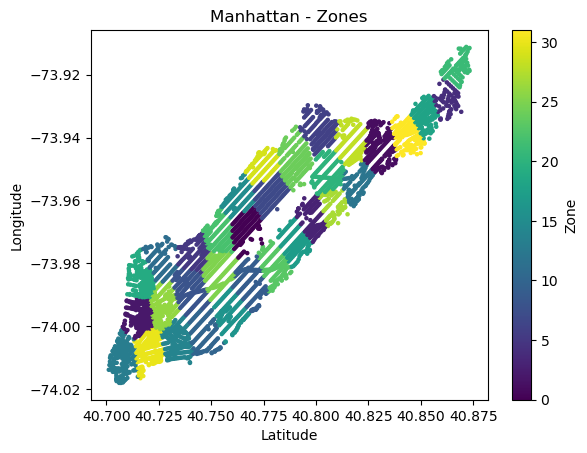

In [29]:
map_Nodes = copy.deepcopy(Nodes)

map_Nodes.reset_index(drop=True, inplace=True)

#Rename Columns
map_Nodes.columns = ['node_id', 'latitude', 'longitude']
map_Nodes['node_id'] = map_Nodes['node_id'].astype(int)

# FillNA
map_Nodes.loc[map_Nodes['node_id'] == 3019, 'longitude'] = -73.950005

# get coordinates
coordinates = map_Nodes[['latitude', 'longitude']].values

k = 32
kmeans = KMeans(n_clusters=k, random_state=0).fit(coordinates)

map_Nodes['zone_id'] = kmeans.labels_

# 可视化聚类结果，不包括孤立节点
plt.scatter(map_Nodes['latitude'], map_Nodes['longitude'], 
            c=map_Nodes['zone_id'], cmap='viridis', s= 5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Manhattan - Zones')
plt.colorbar(label='Zone')
plt.savefig(osp.join(BASEDIR, OUTPUT_NAME + '_Node_Clustering.png'),dpi=300)
plt.show()

# pickle nodes
with open(osp.join(BASEDIR, OUTPUT_NAME + '_Nodes.pickle'), 'wb') as f:
    pickle.dump(map_Nodes, f)


In [ ]:
# ADJ MATRIX on ZONES
# 创建网络图，并添加所有节点和边
G = nx.DiGraph()

# 添加所有节点
for node_id in map_Nodes['node_id']:
    G.add_node(node_id)

# 添加边
num_edges = len(map_Edges)
arcs = tqdm(map_Edges.iterrows(), total=num_edges, ncols=100, desc='Building network...')
for idx, arc in arcs:
    Oid = arc['Oid']
    Did = arc['Did']
    TimeCost = arc['ArcTime']
    G.add_edge(Oid, Did, TimeCost=TimeCost)

print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

# 初始化邻接矩阵
area_adjacency_matrix = np.zeros((k, k), dtype=int)

# 检查邻接关系
for node in map_Nodes['node_id']:
    node_zone = map_Nodes.loc[map_Nodes['node_id'] == node, 'zone_id'].values[0]
    neighbors = list(G.neighbors(node))

    for neighbor in neighbors:
        neighbor_zone = map_Nodes.loc[map_Nodes['node_id'] == neighbor, 'zone_id'].values[0]

        # 标记不同区域间的直接相邻关系
        if node_zone != neighbor_zone and neighbor_zone != -1:
            area_adjacency_matrix[node_zone, neighbor_zone] = 1
            area_adjacency_matrix[neighbor_zone, node_zone] = 1  # 确保对称

# 添加自环
np.fill_diagonal(area_adjacency_matrix, 1)

# 输出并保存邻接矩阵
print("Area Adjacency Matrix:")
print(area_adjacency_matrix)

# # 保存邻接矩阵到CSV
# np.savetxt(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Matrix.csv'), area_adjacency_matrix, delimiter=",", fmt='%d')

# pickle保存
with open(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Matrix.pickle'), 'wb') as f:
    pickle.dump(area_adjacency_matrix, f)

Building network...: 100%|███████████████████████████████████| 9452/9452 [00:00<00:00, 40715.38it/s]


Network has 4091 nodes and 9452 edges.
Area Adjacency Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 1 0]
 [0 1 0 ... 0 0 1]]


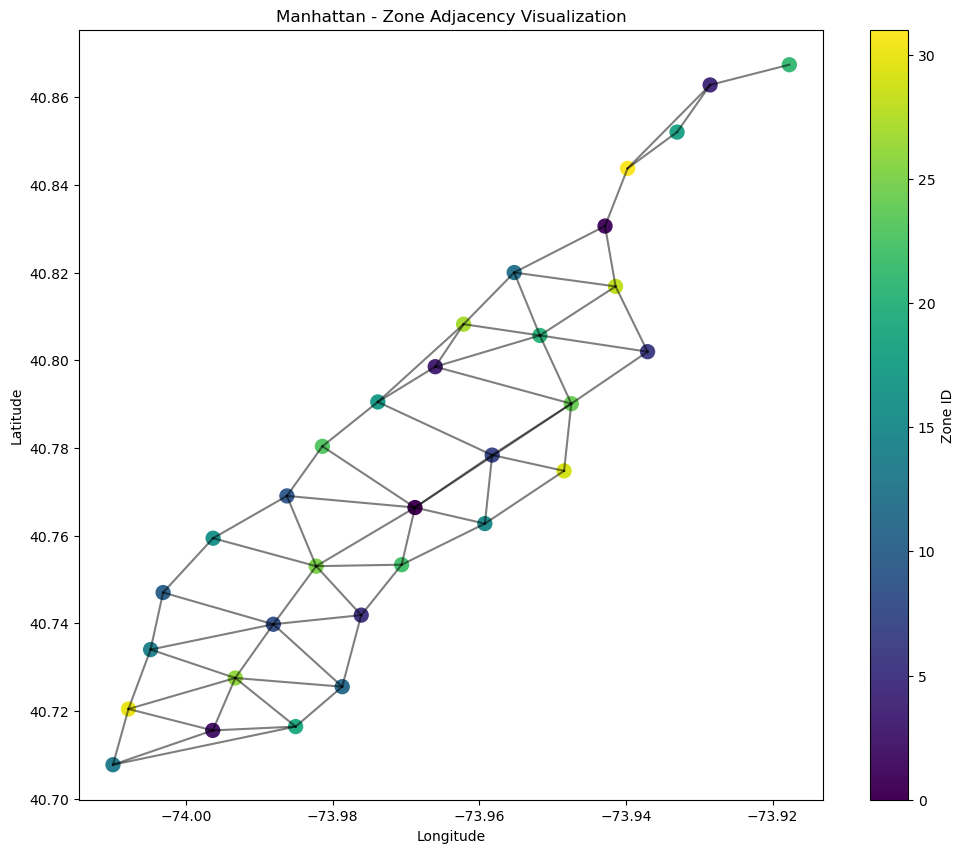

In [10]:
# ZONE ADJACENCY VISUALIZATION
# 计算每个区域的质心
centroids = map_Nodes.groupby('zone_id')[['latitude', 'longitude']].mean()

# 创建图
plt.figure(figsize=(12, 10))

# 绘制每个区域的质心
plt.scatter(centroids['longitude'], centroids['latitude'], c=centroids.index, cmap='viridis', s=100, label='Zone Centroids')
plt.colorbar(label='Zone ID')

# 根据邻接矩阵绘制相邻区域之间的连线
for i in range(k):
    for j in range(i+1, k):  # 避免重复绘制对称线
        if area_adjacency_matrix[i, j] == 1:
            # 获取相邻区域的质心
            lat1, lon1 = centroids.loc[i]
            lat2, lon2 = centroids.loc[j]
            # 绘制连接线
            plt.plot([lon1, lon2], [lat1, lat2], 'k-', alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Manhattan - Zone Adjacency Visualization")

#save image
plt.savefig(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Visualization.png'))
plt.show()


In [11]:
map_AdjacencyV = copy.deepcopy(AdjacencyV)
# add one to index of column and row index make it 1-indexed
map_AdjacencyV.index = AdjacencyV.index + 1
map_AdjacencyV.columns = AdjacencyV.columns + 1

# Add self-Connection to AdjacencyV
for i in range(map_AdjacencyV.shape[0]):
    map_AdjacencyV.loc[i+1,i+1] = 1

# AdjacencyV.drop(AdjacencyV.index[-1], inplace=True) # remove last row
# AdjacencyV.drop(AdjacencyV.columns[0], axis=1, inplace=True) # remove first column
map_AdjacencyV = map_AdjacencyV.astype(int) # trun to integer

# save adjacency as pickle
with open(osp.join(BASEDIR,OUTPUT_NAME + '_Node_Adjacency_Matrix.pickle'), 'wb') as f:
    pickle.dump(map_AdjacencyV, f)

map_AdjacencyV

,1,2,3,4,5,6,7,8,9,10,...,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4089,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
4090,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [31]:
EdgeTimes

,0
0,16
1,30
2,38
3,11
4,23
...,...
9447,37
9448,93
9449,45
9450,22


In [38]:
# Compute all path matrix (Efficient!)

# Generate Graph
G = nx.DiGraph()
num_edges = len(map_Edges) #num of edges in the map
num_of_nodes = len(map_Nodes) #num of nodes in the map
arcs = tqdm(map_Edges.iterrows(), total=num_edges, ncols=100, desc='Building network...') #ncols is the width of the progress bar

for idx, arcs in arcs:
    Oid = arcs['Oid']
    Did = arcs['Did']
    arc_id = arcs['EdgeID']
    ArcTime = EdgeTimes.iloc[arc_id-1]['ArcTime']
    G.add_node(Oid) #add current node to the graph
    G.add_node(Did) #add destination node to the graph
    G.add_edge(Oid, Did, TimeCost=ArcTime) #add the arc to the graph

print('Network data loaded.')
print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

all_path_matrix = np.zeros((G.number_of_nodes()+1, G.number_of_nodes()+1))

nodes = tqdm(range(1, num_of_nodes+1), ncols=100, desc='Computing all_path_matrix')
for current_node in nodes:
    path = dict(nx.single_source_dijkstra_path(G, current_node, cutoff=None, weight='TimeCost'))
    # timeCost = dict(nx.single_source_dijkstra_path_length(G, current_node, cutoff=None, weight='TimeCost'))
    for target_node_ID in range(1, num_of_nodes+1):
        current_path = path[target_node_ID]
        for node_idx in range(len(current_path)):
            if node_idx == len(current_path)-1: #last node, also handle self-connection route
                all_path_matrix[current_path[node_idx]][target_node_ID] = int(target_node_ID)
                continue
            all_path_matrix[current_path[node_idx]][target_node_ID] = int(current_path[node_idx+1])
            
temp_all_path_matrix = copy.deepcopy(pd.DataFrame(all_path_matrix))
temp_all_path_matrix = temp_all_path_matrix.drop(index=0).drop(columns=temp_all_path_matrix.columns[0])
temp_all_path_matrix = temp_all_path_matrix.astype(int)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix.pickle'), 'wb') as f:
    pickle.dump(temp_all_path_matrix, f)

Building network...: 100%|███████████████████████████████████| 9452/9452 [00:00<00:00, 37644.47it/s]


Network data loaded.
Network has 4091 nodes and 9452 edges.


Computing all_path_matrix: 100%|████████████████████████████████| 4091/4091 [05:04<00:00, 13.45it/s]


In [7]:
with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix.pickle'), 'rb') as f:
    all_path_matrix = pickle.load(f)

# convert to numpy array
all_path_matrix = np.array(all_path_matrix)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix_Array.pickle'), 'wb') as f:
    pickle.dump(all_path_matrix, f)


In [39]:
# Save all path time matrix (Efficient!)
map_dijkstra_V = copy.deepcopy(dijkstra_V).T
# add 1 to column and row
map_dijkstra_V.index = dijkstra_V.index + 1
map_dijkstra_V.columns = dijkstra_V.columns + 1

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathTimeMatrix.pickle'), 'wb') as f:
     pickle.dump(map_dijkstra_V, f)

map_dijkstra_V

,1,2,3,4,5,6,7,8,9,10,...,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091
1,0,53,85,23,47,74,76,42,54,93,...,2579,2553,2630,2583,2620,2559,2706,2609,2723,2661
2,35,0,81,19,43,70,35,38,28,89,...,2575,2549,2626,2579,2616,2555,2702,2605,2719,2657
3,122,136,0,106,70,22,150,65,128,41,...,2559,2533,2610,2563,2600,2539,2686,2589,2703,2641
4,16,30,62,0,24,51,53,19,31,70,...,2556,2530,2607,2560,2597,2536,2683,2586,2700,2638
5,69,83,55,53,0,44,97,12,75,63,...,2549,2523,2600,2553,2590,2529,2676,2579,2693,2631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,2634,2623,2545,2618,2582,2534,2585,2577,2640,2518,...,66,15,117,70,82,0,193,96,210,148
4088,2718,2707,2629,2702,2666,2618,2669,2661,2724,2602,...,85,155,68,98,222,162,0,59,161,22
4089,2659,2648,2570,2643,2607,2559,2610,2602,2665,2543,...,26,96,77,39,163,103,97,0,170,52
4090,2681,2670,2592,2665,2629,2581,2632,2624,2687,2565,...,48,119,31,106,186,125,121,78,0,76


In [9]:
# check everything
with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix.pickle'), 'rb') as f:
    new_All_path_matrix = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathTimeMatrix.pickle'), 'rb') as f:
    new_All_path_time_matrix = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_Node_Adjacency_Matrix.pickle'), 'rb') as f:
    new_Node_adjacency = pickle.load(f)\

with open(osp.join(BASEDIR,OUTPUT_NAME + '_Nodes.pickle'), 'rb') as f:
    new_Nodes = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_Zone_Adjacency_Matrix.pickle'), 'rb') as f:
    new_Zone_adj_matrix = pickle.load(f)

# load old
OLD_OUTPUT_NAME = 'NYC_Manhattan'
with open(osp.join(BASEDIR,OLD_OUTPUT_NAME + '_AllPathMatrix.pickle'), 'rb') as f:
    old_All_path_matrix = pickle.load(f)

with open(osp.join(BASEDIR,OLD_OUTPUT_NAME + '_AllPathTimeMatrix.pickle'), 'rb') as f:
    old_All_path_time_matrix = pickle.load(f)

with open(osp.join(BASEDIR,OLD_OUTPUT_NAME + '_CityArc.pickle'), 'rb') as f:
    old_Node_adjacency = pickle.load(f)

old_Nodes = pd.read_csv(osp.join(BASEDIR,OLD_OUTPUT_NAME + '_Nodes_Lookup_Table.csv'))

with open(osp.join(BASEDIR,OLD_OUTPUT_NAME + '_AREA_Adjacency_Matrix.pickle'), 'rb') as f:
    old_Zone_adj_matrix = pickle.load(f)



In [58]:
# check if the new and old are the same
print("All Path Matrix is the same: ", np.array_equal(new_All_path_matrix, old_All_path_matrix))
print("All Path Time Matrix is the same: ", np.array_equal(new_All_path_time_matrix, old_All_path_time_matrix))
print("Node Adjacency Matrix is the same: ", np.array_equal(new_Node_adjacency, old_Node_adjacency))
print("Node Matrix is the same: ", np.array_equal(new_Nodes.values, old_Nodes.values))
print("Zone Adjacency Matrix is the same: ", np.array_equal(new_Zone_adj_matrix, old_Zone_adj_matrix))


All Path Matrix is the same:  True
All Path Time Matrix is the same:  True
Node Adjacency Matrix is the same:  True
Node Matrix is the same:  False
Zone Adjacency Matrix is the same:  False


In [62]:
len(old_All_path_matrix[0])

4092

In [21]:
new_All_path_matrix[2504][2485]

2505

In [16]:
old_All_path_matrix[2503][2484]

2445.0

In [19]:
pd.DataFrame(old_All_path_matrix)

,0,1,2,3,4,5,6,7,8,9,...,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,0.0,4.0,2.0,4.0,4.0,4.0,4.0,7.0,4.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
3,0.0,6.0,6.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
4,0.0,1.0,2.0,8.0,4.0,8.0,8.0,2.0,8.0,2.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,0.0,4081.0,4081.0,4081.0,4081.0,4081.0,4081.0,4081.0,4081.0,4081.0,...,4081.0,4081.0,4081.0,4081.0,4081.0,4087.0,4081.0,4081.0,4081.0,4081.0
4088,0.0,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,...,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,4088.0,4091.0,4091.0,4091.0
4089,0.0,4082.0,4082.0,4082.0,4082.0,4082.0,4082.0,4082.0,4082.0,4082.0,...,4082.0,4082.0,4082.0,4085.0,4082.0,4082.0,4091.0,4089.0,4082.0,4091.0
4090,0.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,...,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4084.0,4090.0,4084.0
